In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install albumentations

# **1- Importing required libraries**

In [31]:
import os
import cv2
import time
from glob import glob
from tqdm import tqdm
import numpy as np 
import cv2 as cv
import zipfile
import io
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
from sklearn.impute import SimpleImputer
import albumentations
from sklearn.model_selection import train_test_split
from scipy.ndimage.morphology import binary_dilation
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms
import torchvision.transforms.functional as TF
from torchvision.utils import make_grid

from PIL import Image

# You can use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass

warnings.warn = warn
warnings.filterwarnings('ignore')

# **2- Data Preprocessing**

<div style="background-color: green; padding: 10px; border-radius: 10px; ">
<font size="4px" color="white">
<hr style="color: red;">
Get all files
<hr style="color: red;">
</font>
</div>

In [4]:
data_dir = '/kaggle/input/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/'
data_dir = glob(f'{data_dir}/*/*[0-9].tif')

<div style="background-color: green; padding: 10px; border-radius: 10px; ">
<font size="4px" color="white">
<hr style="color: red;">
Read csv file of data
<hr style="color: red;">
</font>
</div>

In [5]:
csv_path = '/kaggle/input/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/data.csv'
df = pd.read_csv(csv_path)

missing_values_count = df.isnull().sum()
missing_values_count

Patient                       0
RNASeqCluster                18
MethylationCluster            1
miRNACluster                  0
CNCluster                     2
RPPACluster                  12
OncosignCluster               5
COCCluster                    0
histological_type             1
neoplasm_histologic_grade     1
tumor_tissue_site             1
laterality                    1
tumor_location                1
gender                        1
age_at_initial_pathologic     1
race                          2
ethnicity                     8
death01                       1
dtype: int64

<div style="background-color: green; padding: 10px; border-radius: 10px; ">
<font size="4px" color="white">
<hr style="color: red;">
Missing values handling
<hr style="color: red;">
</font>
</div>

In [6]:
imputer = SimpleImputer(strategy="most_frequent")
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
df.head()

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,2.0,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,2.0,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,2.0,0.0
3,TCGA_CS_4944,2.0,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,2.0,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,2.0,0.0


<div style="background-color: green; padding: 10px; border-radius: 10px; ">
<font size="4px" color="white">
<hr style="color: red;">
Function to get data
<hr style="color: red;">
</font>
</div>

In [7]:
def get_file_row(path):
    """Produces ID of a patient, image and mask filenames from a particular path"""
    path_no_ext, ext = os.path.splitext(path)
    filename = os.path.basename(path)
    
    patient_id = '_'.join(filename.split('_')[:3]) # Patient ID in the csv file consists of 3 first filename segments
    
    return [patient_id, path, f'{path_no_ext}_mask{ext}']

<div style="background-color: green; padding: 10px; border-radius: 10px; ">
<font size="4px" color="white">
<hr style="color: red;">
Store the data into a dataframe
<hr style="color: red;">
</font>
</div>

In [8]:
PathDF = pd.DataFrame((get_file_row(filename) for filename in data_dir), columns=['Patient', 'image', 'mask'])
PathDF.head()

,Patient,image,mask
0,TCGA_DU_7010,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...
1,TCGA_DU_7010,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...
2,TCGA_DU_7010,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...
3,TCGA_DU_7010,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...
4,TCGA_DU_7010,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...


<div style="background-color: green; padding: 10px; border-radius: 10px; ">
<font size="4px" color="white">
<hr style="color: red;">
Dataset Class
<hr style="color: red;">
</font>
</div>

In [9]:
class MRI_Dataset(Dataset):
    def __init__(self, df, transform=None):
        super(MRI_Dataset, self).__init__()
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, idx, raw=False):
        row = self.df.iloc[idx]
        img = cv2.imread(row['image'], cv2.IMREAD_UNCHANGED)
        mask = cv2.imread(row['mask'], cv2.IMREAD_GRAYSCALE)
        if raw:
            return img, mask
        
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            image, mask = augmented['image'], augmented['mask']
        
        img = transforms.functional.to_tensor(img)
        mask = mask // 255
        mask = torch.Tensor(mask)
        return img, mask

In [10]:
df = pd.merge(df, PathDF, on="Patient")

<div style="background-color: green; padding: 10px; border-radius: 10px; ">
<font size="4px" color="white">
<hr style="color: red;">
Split data into train, valid, and test
<hr style="color: red;">
</font>
</div>

In [11]:
train_df, rest = train_test_split(df, test_size=0.3, random_state=42)
test_df, valid_df = train_test_split(rest, test_size=0.3, random_state=42)

print(f"Train: {train_df.shape[0]} | Validation: {valid_df.shape[0]} | Test: {test_df.shape[0]}")

Train: 2750 | Validation: 354 | Test: 825


<div style="background-color: green; padding: 10px; border-radius: 10px; ">
<font size="4px" color="white">
<hr style="color: red;">
Data transformation and loaders
<hr style="color: red;">
</font>
</div>

In [12]:
transform = albumentations.Compose([
    albumentations.ChannelDropout(p=0.3),
    albumentations.RandomBrightnessContrast(p=0.3),
    albumentations.ColorJitter(p=0.3),
])

train_dataset = MRI_Dataset(train_df, transform)
valid_dataset = MRI_Dataset(valid_df)
test_dataset = MRI_Dataset(test_df)

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1)

<div style="background-color: green; padding: 10px; border-radius: 10px; ">
<font size="4px" color="white">
<hr style="color: red;">
Show sample
<hr style="color: red;">
</font>
</div>

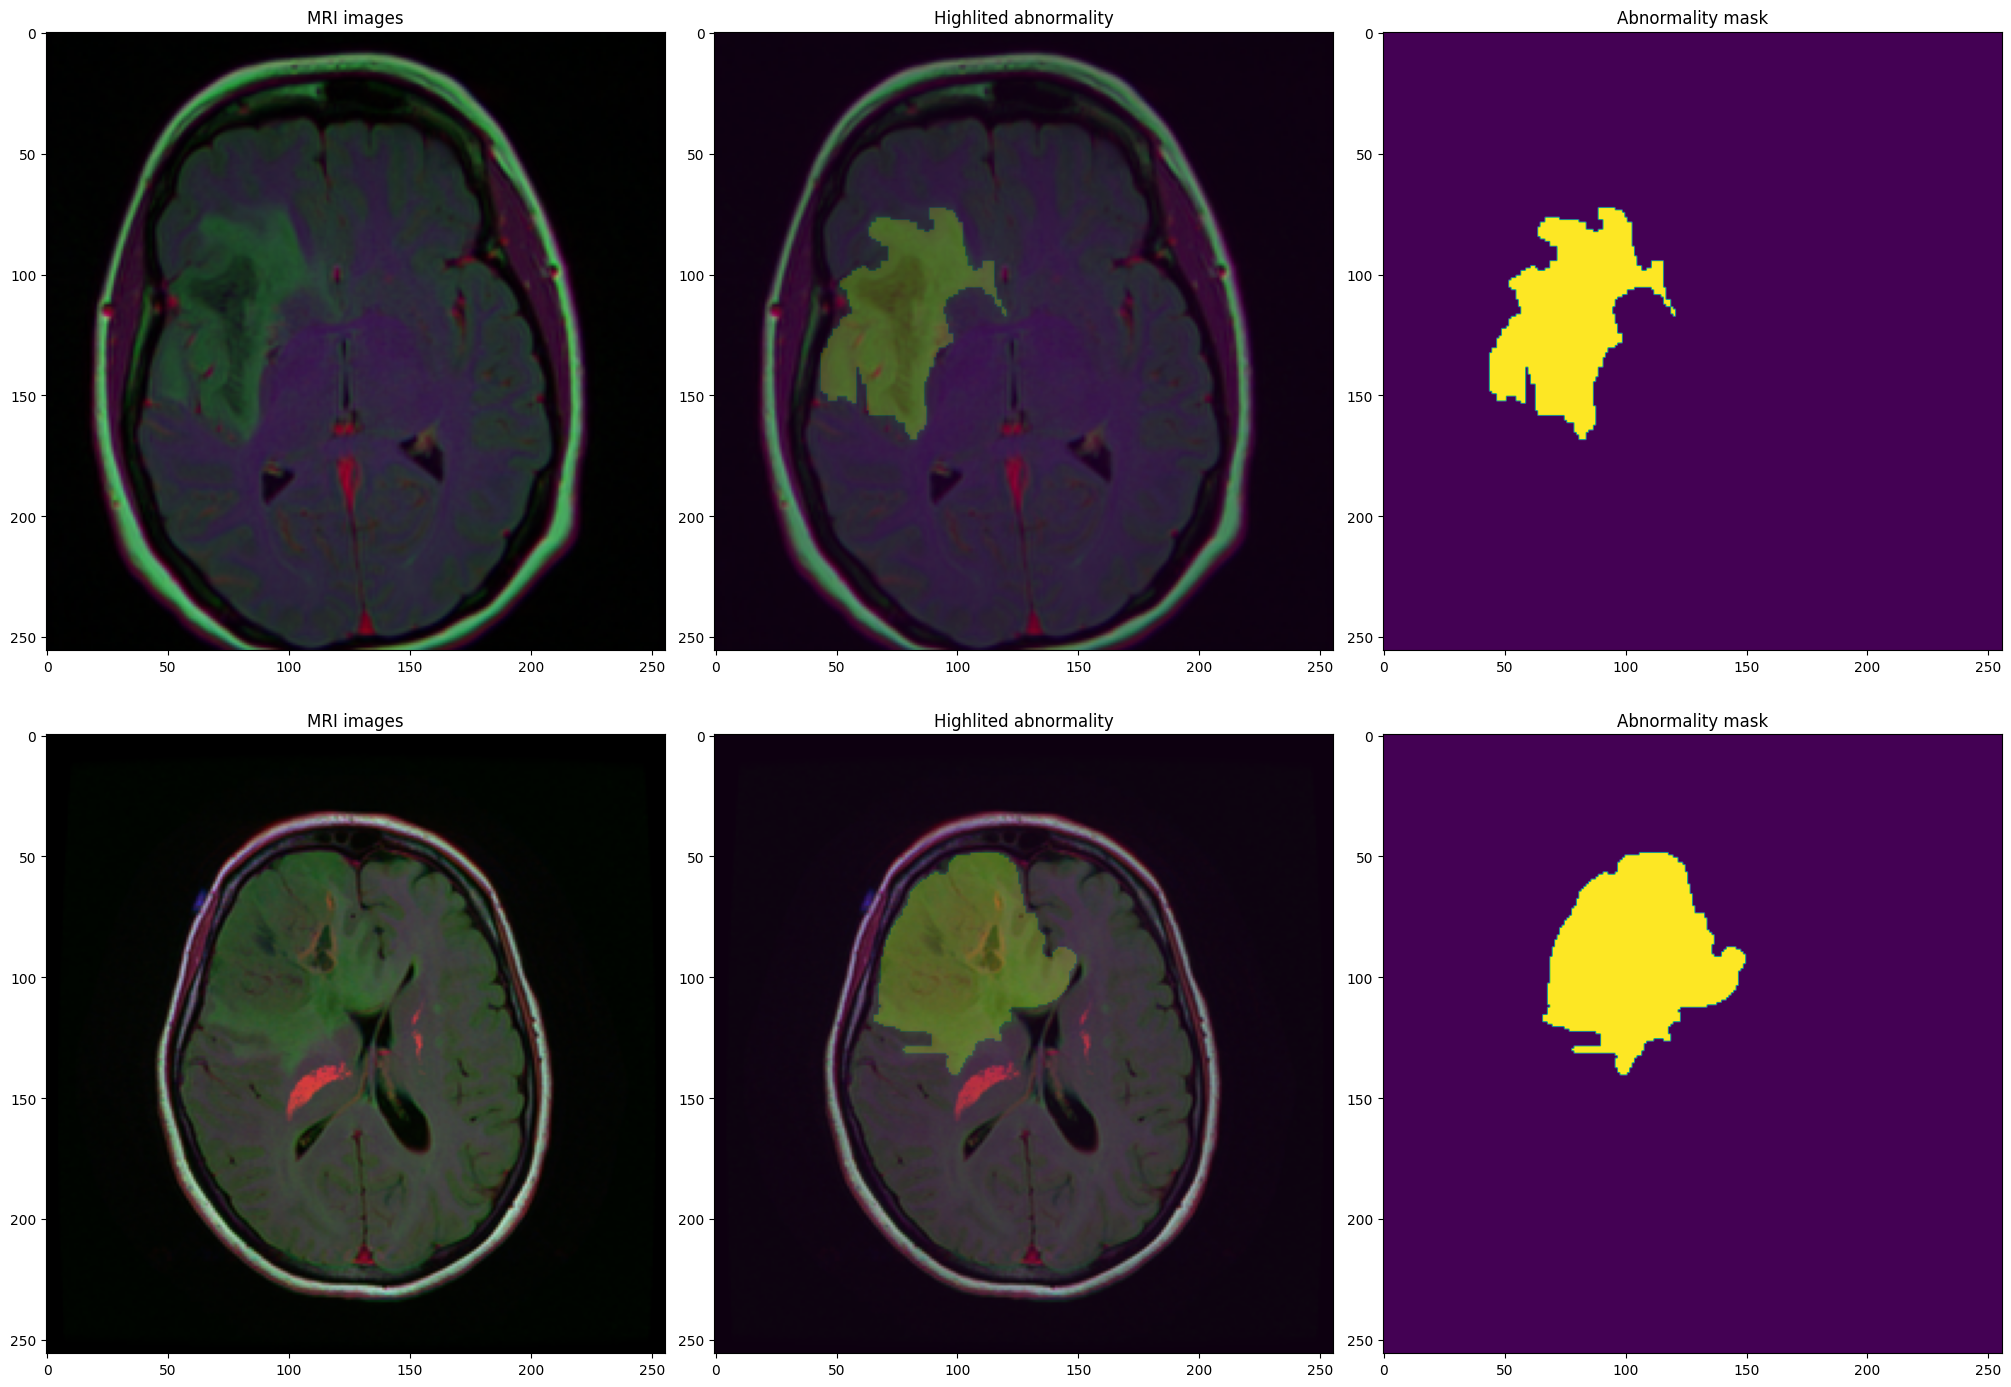

In [13]:
%matplotlib inline
n_examples = 2

fig, axs = plt.subplots(n_examples, 3, figsize=(20, n_examples*7), constrained_layout=True)
i = 0
for ax in axs:
    while True:
        image, mask = train_dataset.__getitem__(i, raw=True)
        i += 1
        if np.any(mask): 
            ax[0].set_title("MRI images")
            ax[0].imshow(image)
            ax[1].set_title("Highlited abnormality")
            ax[1].imshow(image)
            ax[1].imshow(mask, alpha=0.2)
            ax[2].imshow(mask)
            ax[2].set_title("Abnormality mask")
            break

# **3- Creating the U-Net architecture**

<div style="background-color: green; padding: 10px; border-radius: 10px; ">
<font size="4px" color="white">
<hr style="color: red;">
Building the convolutional block 
<hr style="color: red;">
</font>
</div>

In [14]:
class double_convolution(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(double_convolution, self).__init__()
        self.conv = nn.Sequential( 
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
         )
    def forward(self, x):
        x = self.conv(x)
        return x

In [15]:
class InConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(InConv, self).__init__()
        self.conv = double_convolution(in_channels, out_channels)
    def forward(self, x):
        x = self.conv(x)
        return x

<div style="background-color: green; padding: 10px; border-radius: 10px; ">
<font size="4px" color="white">
<hr style="color: red;">
Building the encoder  
<hr style="color: red;">
</font>
</div>

In [16]:
class downsample_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(downsample_block, self).__init__()
        self.Downconv = nn.Sequential( 
            nn.MaxPool2d(2,2),
            double_convolution(in_channels, out_channels)
         )
    def forward(self, x):
        x = self.Downconv(x)
        return x

<div style="background-color: green; padding: 10px; border-radius: 10px; ">
<font size="4px" color="white">
<hr style="color: red;">
Building the decoder  
<hr style="color: red;">
</font>
</div>

In [17]:
class upsample_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(upsample_block, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
        self.conv = double_convolution(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

In [18]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.conv(x)
        x = self.sigmoid(x)
        return x

<div style="background-color: green; padding: 10px; border-radius: 10px; ">
<font size="4px" color="white">
<hr style="color: red;">
Building UNet model  
<hr style="color: red;">
</font>
</div>

In [19]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(UNet, self).__init__()
        self.inc = InConv(in_channels, 64)
        self.down1 = downsample_block(64, 128)
        self.down2 = downsample_block(128, 256)
        self.down3 = downsample_block(256, 512)
        self.down4 = downsample_block(512, 512)
        self.up1 = upsample_block(1024, 256)
        self.up2 = upsample_block(512, 128)
        self.up3 = upsample_block(256, 64)
        self.up4 = upsample_block(128, 64)
        self.outc = OutConv(64, num_classes)
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

In [20]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = UNet(in_channels=3, num_classes=1).to(device)
model.to(device);

In [21]:
# Define our learning rate, loss function and optimizer
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 15

# **4- Training Loop**

In [22]:
def training_loop(epochs, model, train_loader, valid_loader, optimizer, loss_fn):
    history = {'train_loss': [], 'val_loss': []}
    
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        
        running_loss = 0
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            img, mask = data
            img, mask = img.to(device), mask.to(device)
            predictions = model(img)
            predictions = predictions.squeeze(1)
            loss = loss_fn(predictions, mask)
            running_loss += loss.item() * img.size(0)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        model.eval()
        with torch.no_grad():
            running_valid_loss = 0
            for i, data in enumerate(valid_loader):
                img, mask = data
                img, mask = img.to(device), mask.to(device)
                predictions = model(img)
                predictions = predictions.squeeze(1)
                loss = loss_fn(predictions, mask)
                running_valid_loss += loss.item() * img.size(0)
        train_loss = running_loss / len(train_loader.dataset)
        val_loss = running_valid_loss / len(valid_loader.dataset)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        print(f'Epoch: {epoch}/{epochs} | Training loss: {train_loss} | Validation loss: {val_loss}')
    model.eval()
    return history

<div style="background-color: green; padding: 10px; border-radius: 10px; ">
<font size="4px" color="white">
<hr style="color: red;">
Compile model  
<hr style="color: red;">
</font>
</div>

In [47]:
history = training_loop(epochs, model, train_loader, valid_loader, optimizer, loss_fn)

 10%|▉         | 17/172 [00:11<01:46,  1.45it/s]


KeyboardInterrupt: 

<div style="background-color: green; padding: 10px; border-radius: 10px; ">
<font size="4px" color="white">
<hr style="color: red;">
plot results 
<hr style="color: red;">
</font>
</div>

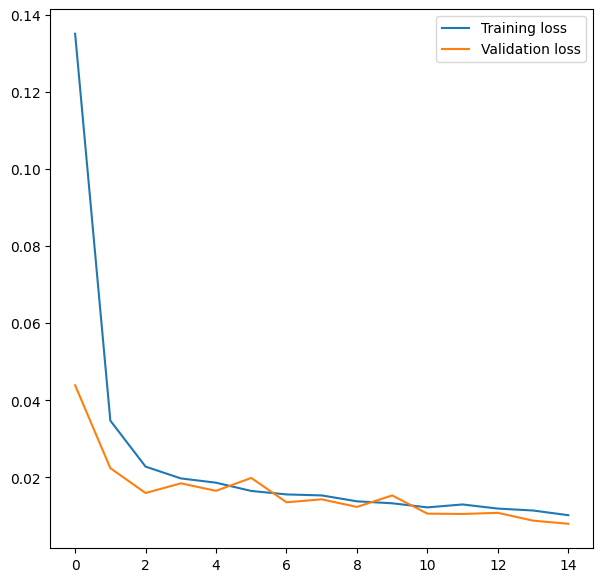

In [26]:
plt.figure(figsize=(7, 7))
plt.plot(history['train_loss'], label='Training loss')
plt.plot(history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# **5- Test Evaluation**

In [27]:
with torch.no_grad():
    running_loss = 0
    for i, data in enumerate(test_loader):
        img, mask = data
        img, mask = img.to(device), mask.to(device)
        predictions = model(img)
        predictions = predictions.squeeze(1)
        loss = loss_fn(predictions, mask)
        running_loss += loss.item() * img.size(0)
    loss = running_loss / len(test_dataset)
    
    print(f'Tests: loss: {loss}')

Tests: loss: 0.010564108033899119


<div style="background-color: green; padding: 10px; border-radius: 10px; ">
<font size="4px" color="white">
<hr style="color: red;">
Testing
<hr style="color: red;">
</font>
</div>

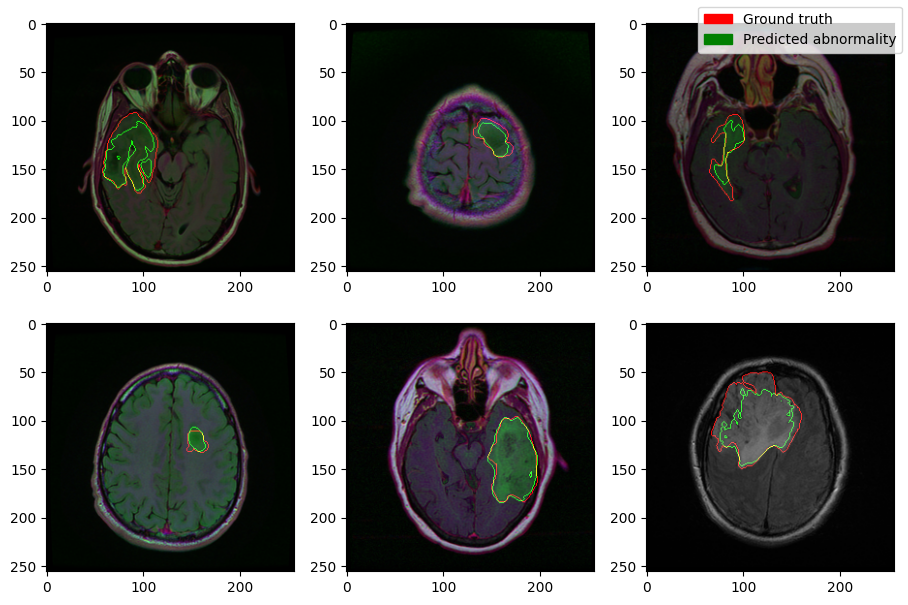

In [46]:
%matplotlib inline

width = 3
columns = 2
n_examples = 6

fig, axs = plt.subplots(columns, width, figsize=(3*width , 3*columns), constrained_layout=True)
red_patch = mpatches.Patch(color='red', label='The red data')
fig.legend(loc='upper right',handles=[
    mpatches.Patch(color='red', label='Ground truth'),
    mpatches.Patch(color='green', label='Predicted abnormality')])
i = 0
with torch.no_grad():
    for data in test_loader:
        image, mask = data
        mask = mask[0]
        if not mask.byte().any():
            continue
        image = image.to(device)
        prediction = model(image).to('cpu')[0][0]
        prediction = torch.where(prediction > 0.5, 1, 0)
        prediction_edges = prediction - binary_dilation(prediction)
        ground_truth = mask - binary_dilation(mask)
        image[0, 0, ground_truth.bool()] = 1
        image[0, 1, prediction_edges.bool()] = 1
        
        axs[i//width][i%width].imshow(image[0].to('cpu').permute(1, 2, 0))
        if n_examples == i + 1:
            break
        i += 1